Solution was inspired by : https://www.kaggle.com/code/masumrumi/a-detailed-regression-guide-with-house-pricing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import missingno as msno

import os
print(os.listdir("dataset"))

import warnings
warnings.filterwarnings('ignore')

['.gitkeep', 'data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


# Explore Dataset
> **Sample Train Dataset**

In [2]:
## Import Trainning data. 
train = pd.read_csv("dataset/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


> **Sample Test Dataset**

In [3]:
## Import test data.
test = pd.read_csv("dataset/test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Describe the Datasets

In [4]:
print (f"Train has {train.shape[0]} rows and {train.shape[1]} columns")
print (f"Test has {test.shape[0]} rows and {test.shape[1]} columns")

Train has 1460 rows and 81 columns
Test has 1459 rows and 80 columns


If you want to know more about why we are splitting dataset's into train and test, please check out this [kernel](https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic).

In [5]:
# gives us statistical info about the numerical variables. 
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [6]:
## Gives us information about the features. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Check how many: Missing Values, Vategorical Values, etc. each feature has

In [7]:
# drop_threshold = 50 
# print("There are {}({:.1f}%) categorical features".format())

In [8]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Checking for Missing Values

### Missing Train values

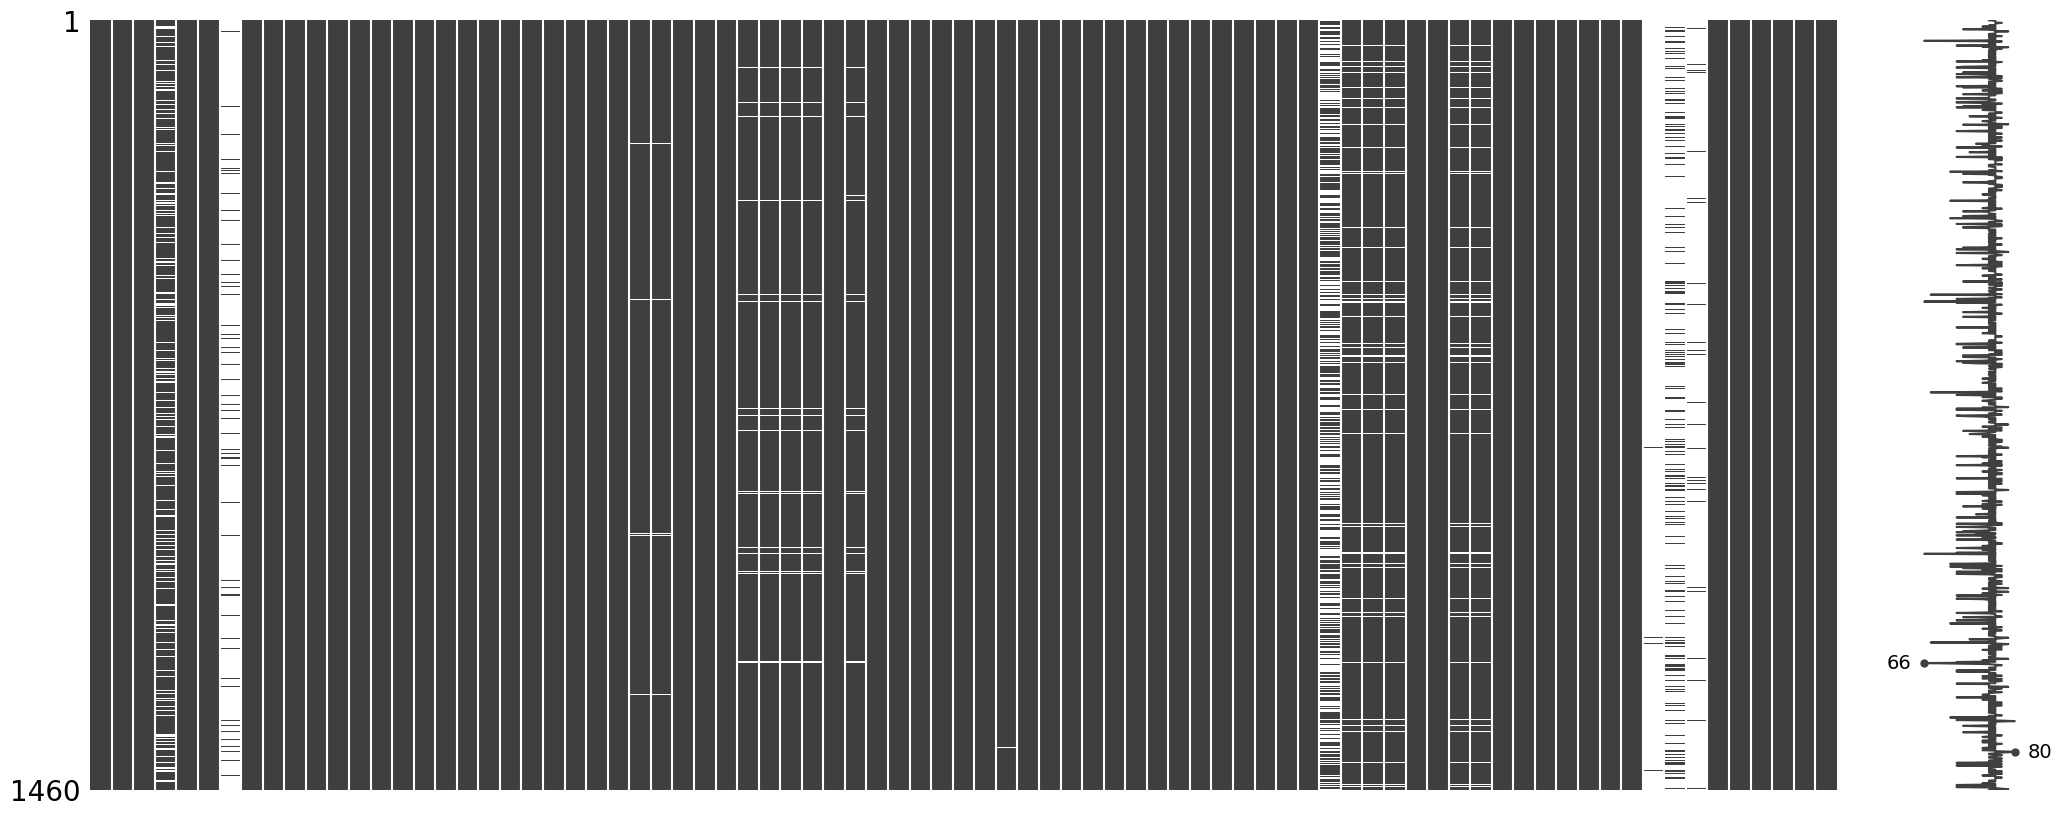

In [9]:
msno.matrix(train);

In [10]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    # Get Missing Velues per feature (exclude features that are complete)
    feature_missing = train.isnull().sum().sort_values(ascending = False)
    feature_missing = feature_missing[feature_missing > 0]
    percent = round(feature_missing/len(df)*100, 2)
    return pd.concat([feature_missing, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


### Missing Test values

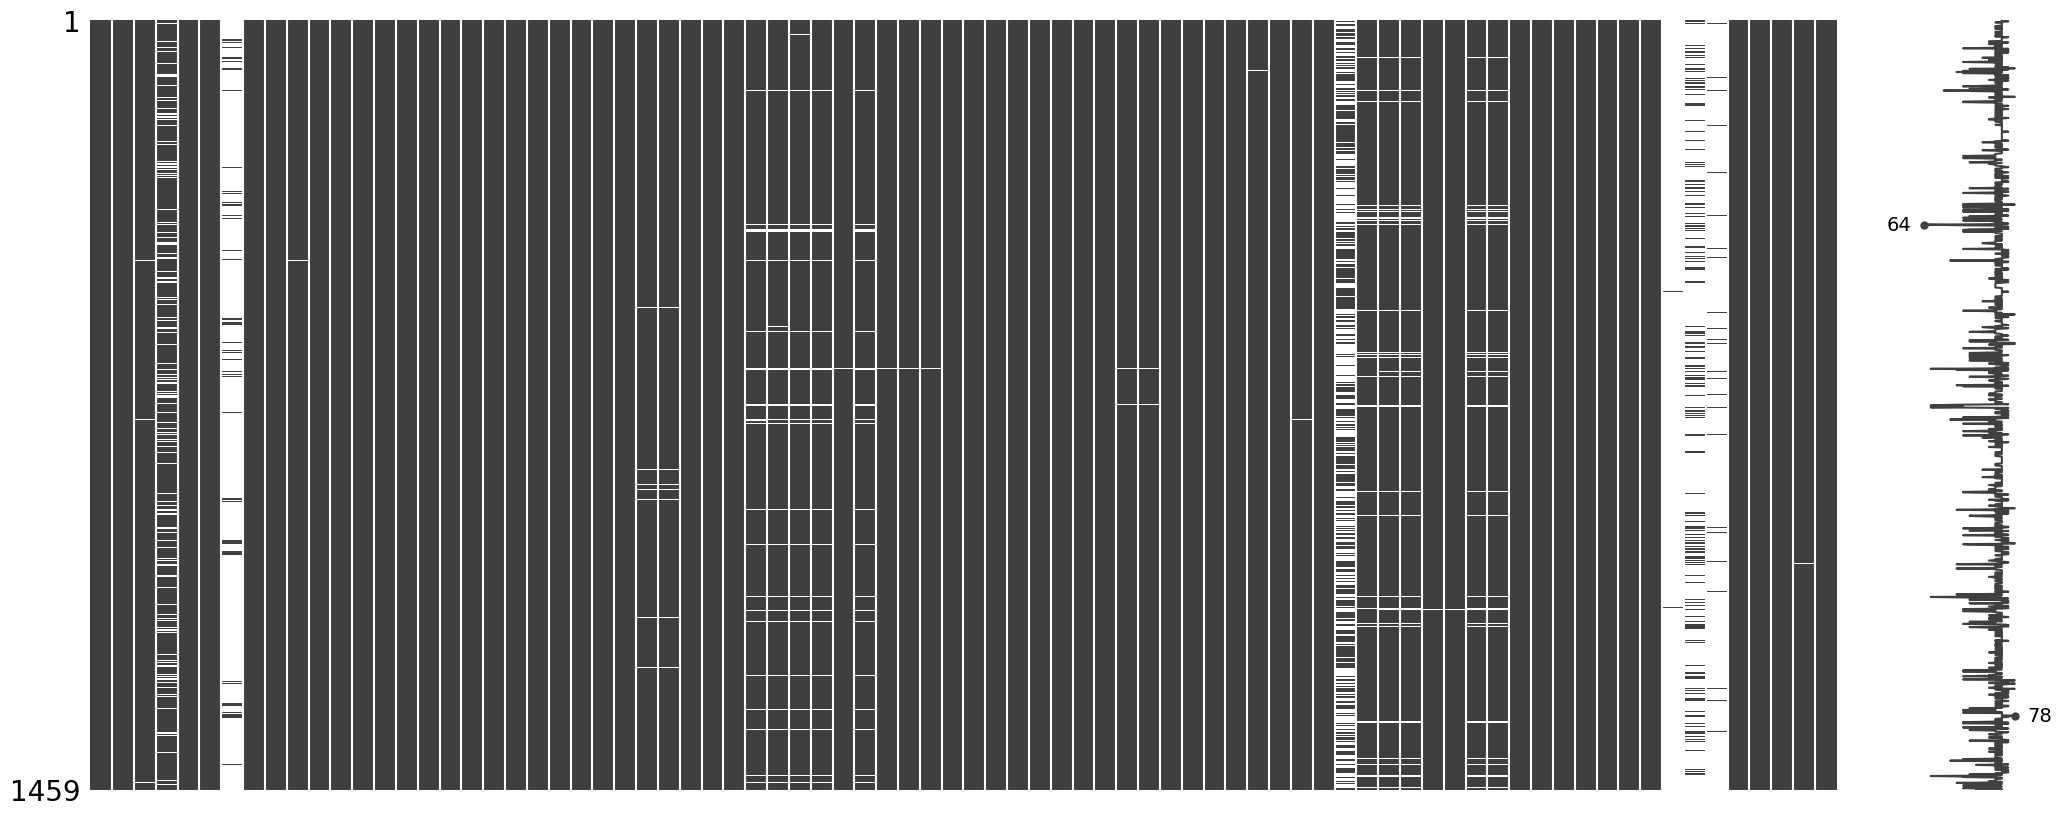

In [11]:
msno.matrix(test);

In [12]:
missing_percentage(test)

,Total,Percent
PoolQC,1453,99.59
MiscFeature,1406,96.37
Alley,1369,93.83
Fence,1179,80.81
FireplaceQu,690,47.29
LotFrontage,259,17.75
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


Makes sence to drop features that have more than 20% of missing values and fill with mean/median the rest of features. Will do it in pre-processign stage

# Observation
* There are multiple types of features. 
* Some features have missing values. 
* Most of the features are object( includes string values in the variable).

I want to focus on the target variable which is **SalePrice.** Let's create a histogram to see if the target variable is Normally distributed. If we want to create any linear model, it is essential that the features are normally distributed. This is one of the assumptions of multiple linear regression. I will explain more on this later.

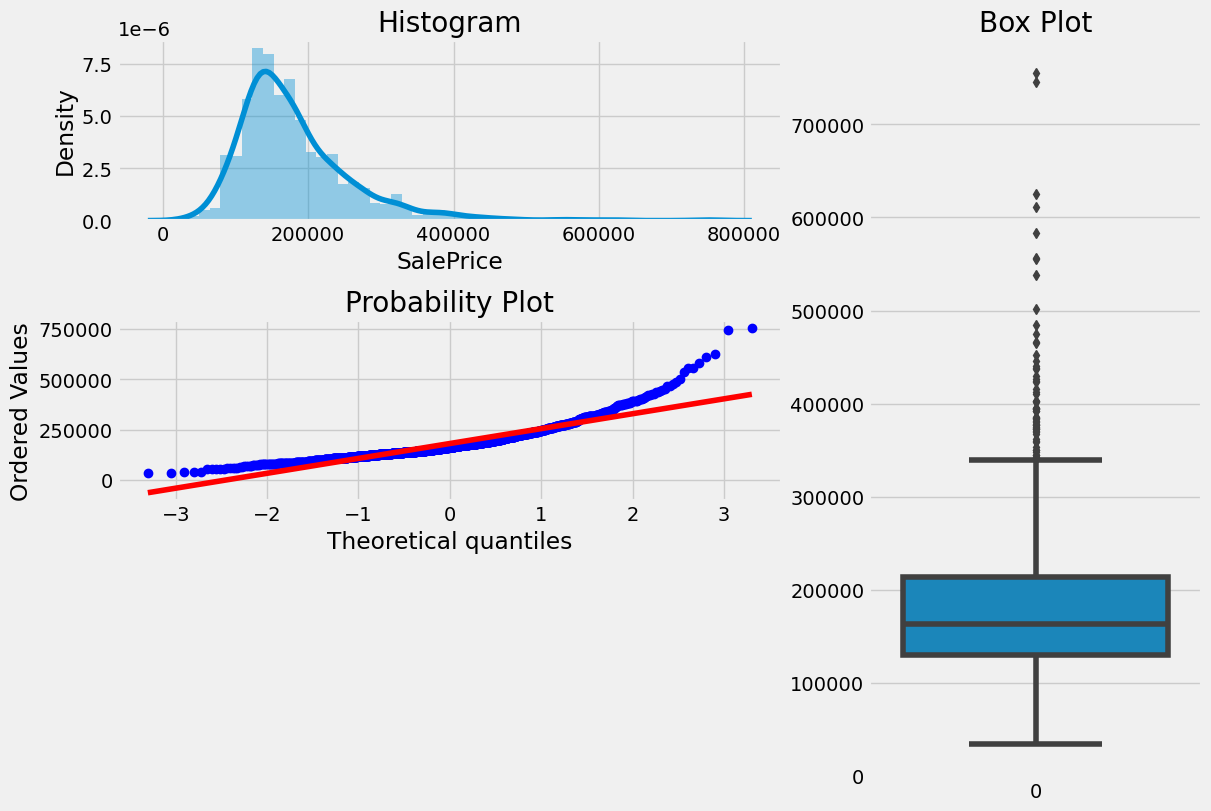

In [13]:
def plotting_3_chart(df, feature):
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(train, 'SalePrice')

These **three** charts above can tell us a lot about our target variable.
* Our target variable, **SalePrice** is not normally distributed.
* Our target variable is right-skewed. 
* There are multiple outliers in the variable.


**P.S.** 
* If you want to find out more about how to customize charts, try [this](https://matplotlib.org/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py) link. 
* If you are learning about Q-Q-plots for the first time. checkout [this](https://www.youtube.com/watch?v=smJBsZ4YQZw) video. 
* You can also check out [this](https://www.youtube.com/watch?v=9IcaQwQkE9I) one if you have some extra time. 

Let's find out how the sales price is distributed.

In [14]:
#skewness and kurtosis
print("Skewness: " + str(train['SalePrice'].skew()))
print("Kurtosis: " + str(train['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


It looks like there are quite a bit Skewness and Kurtosis in the target variable. Let's talk about those a bit. 

<b>Skewness</b> 
* is the degree of distortion from the symmetrical bell curve or the normal curve. 
* So, a symmetrical distribution will have a skewness of "0". 
* There are two types of Skewness: <b>Positive and Negative.</b> 
* <b>Positive Skewness</b>(similar to our target variable distribution) means the tail on the right side of the distribution is longer and fatter. 
* In <b>positive Skewness </b> the mean and median will be greater than the mode similar to this dataset. Which means more houses were sold by less than the average price. 
* <b>Negative Skewness</b> means the tail on the left side of the distribution is longer and fatter.
* In <b>negative Skewness </b> the mean and median will be less than the mode. 
* Skewness differentiates in extreme values in one versus the other tail. 

Here is a picture to make more sense.  
![image](https://cdn-images-1.medium.com/max/1600/1*nj-Ch3AUFmkd0JUSOW_bTQ.jpeg)


<b>Kurtosis</b>
According to Wikipedia, 

*In probability theory and statistics, **Kurtosis** is the measure of the "tailedness" of the probability. distribution of a real-valued random variable.* So, In other words, **it is the measure of the extreme values(outliers) present in the distribution.** 

* There are three types of Kurtosis: <b>Mesokurtic, Leptokurtic, and Platykurtic</b>. 
* Mesokurtic is similar to the normal curve with the standard value of 3. This means that the extreme values of this distribution are similar to that of a normal distribution. 
* Leptokurtic Example of leptokurtic distributions are the T-distributions with small degrees of freedom.
* Platykurtic: Platykurtic describes a particular statistical distribution with thinner tails than a normal distribution. Because this distribution has thin tails, it has fewer outliers (e.g., extreme values three or more standard deviations from the mean) than do mesokurtic and leptokurtic distributions. 

![image](https://i2.wp.com/mvpprograms.com/help/images/KurtosisPict.jpg?resize=375%2C234)


You can read more about this from [this](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa) article. 

We can fix this by using different types of transformation(more on this later). However, before doing that, I want to find out the relationships among the target variable and other predictor variables. Let's find out.

<Axes: >

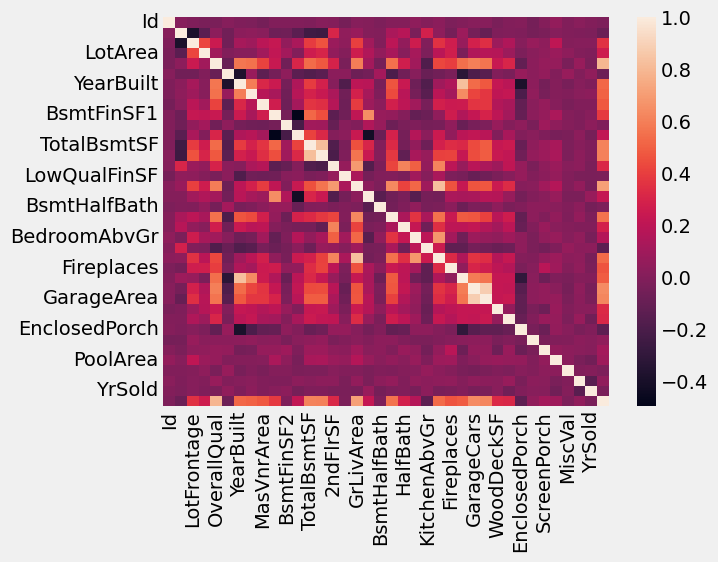

In [15]:
cor = train.corr()
sns.heatmap(cor)

<Axes: title={'center': 'Feature Correlation to Sale Price'}>

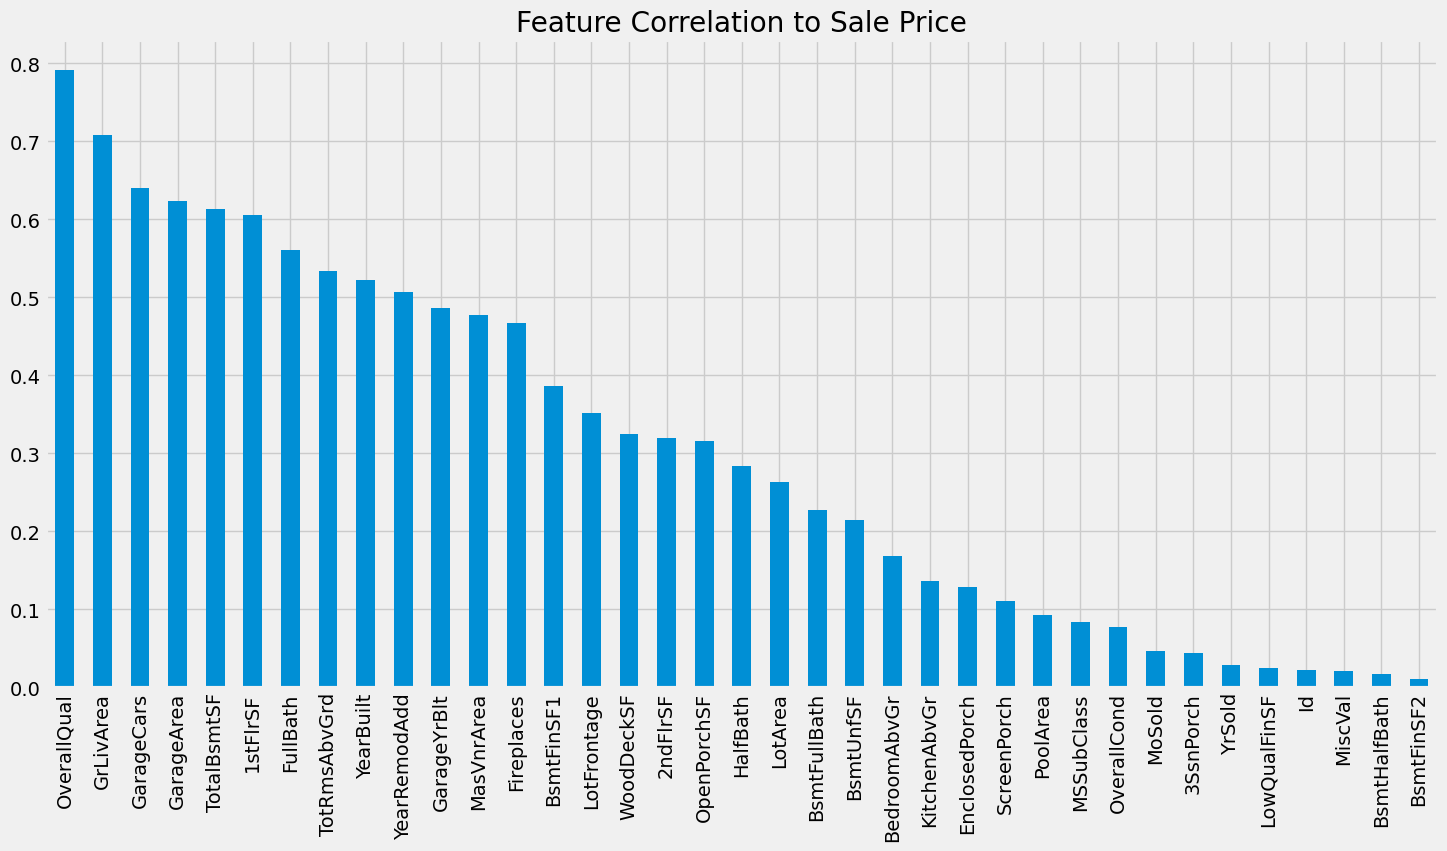

In [16]:
abs(cor["SalePrice"]).drop("SalePrice").sort_values(ascending = False).plot(kind="bar", figsize=(16, 8), title="Feature Correlation to Sale Price")

These are the predictor variables sorted in a descending order starting with the most correlated one **OverallQual**. Let's put this one in a scatter plot and see how it looks.

### SalePrice vs OverallQual

In [17]:
def customized_scatterplot(y, x):
    ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (9, 6))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x);

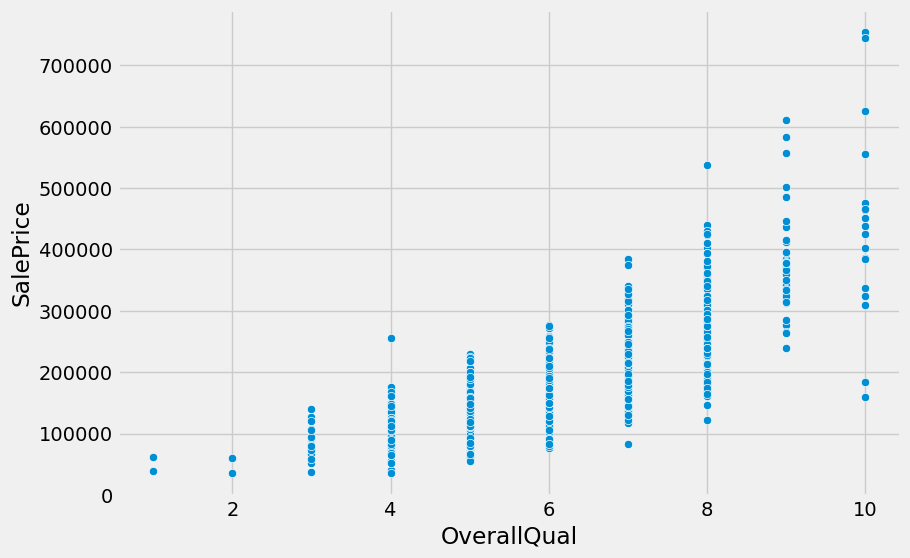

In [18]:
customized_scatterplot(train.SalePrice, train.OverallQual)

**OverallQual** is a categorical variable, and a scatter plot is not the best way to visualize categorical variables. However, there is an apparent relationship between the two features. The price of the houses increases with the overall quality. Let's check out some more features to determine the outliers. Let's focus on the numerical variables this time.

### SalePrice vs GrLivArea

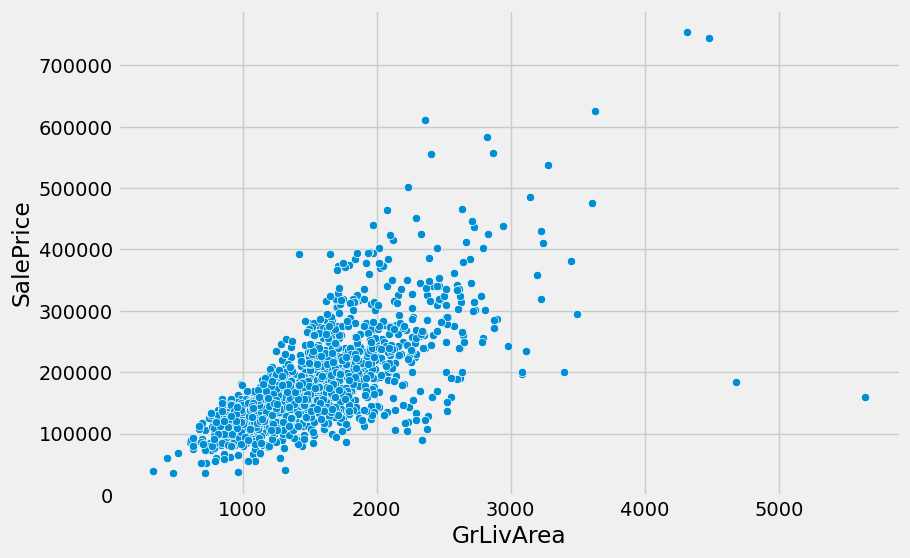

In [19]:
customized_scatterplot(train.SalePrice, train.GrLivArea)

As you can see, there are two outliers in the plot above. We will get rid off them later. Let's look at another scatter plot with a different feature.

### SalePrice vs GarageArea

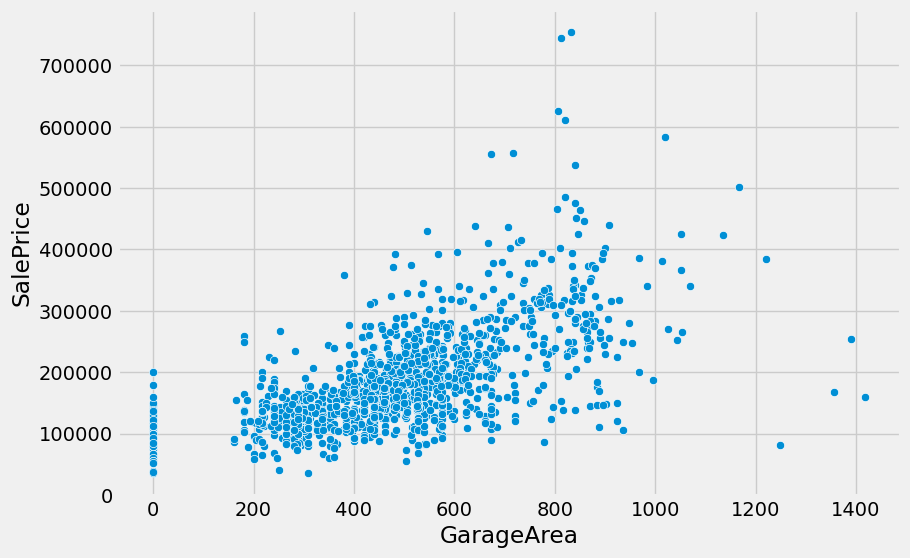

In [20]:
customized_scatterplot(train.SalePrice, train.GarageArea);

And the next one..?
### SalePrice vs TotalBsmtSF

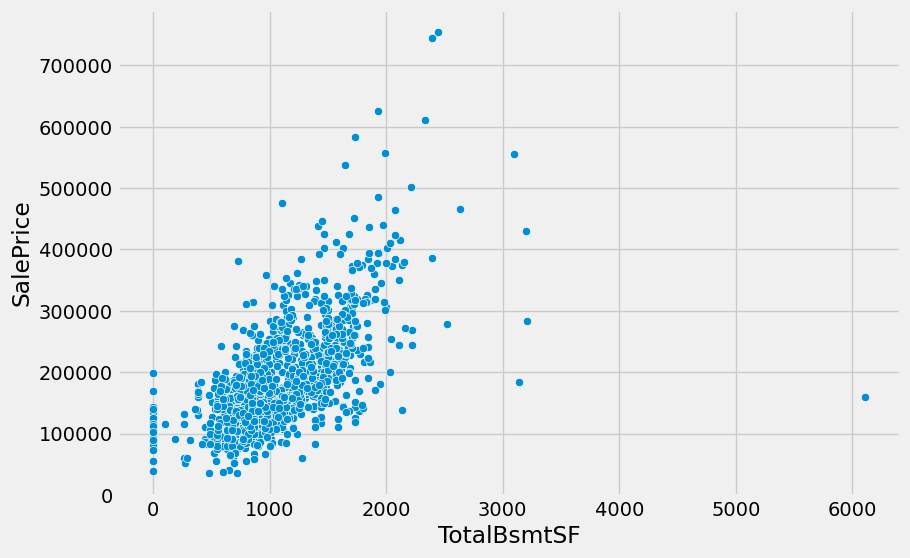

In [21]:
customized_scatterplot(train.SalePrice, train.TotalBsmtSF)

and the next ?
### SalePrice vs 1stFlrSF

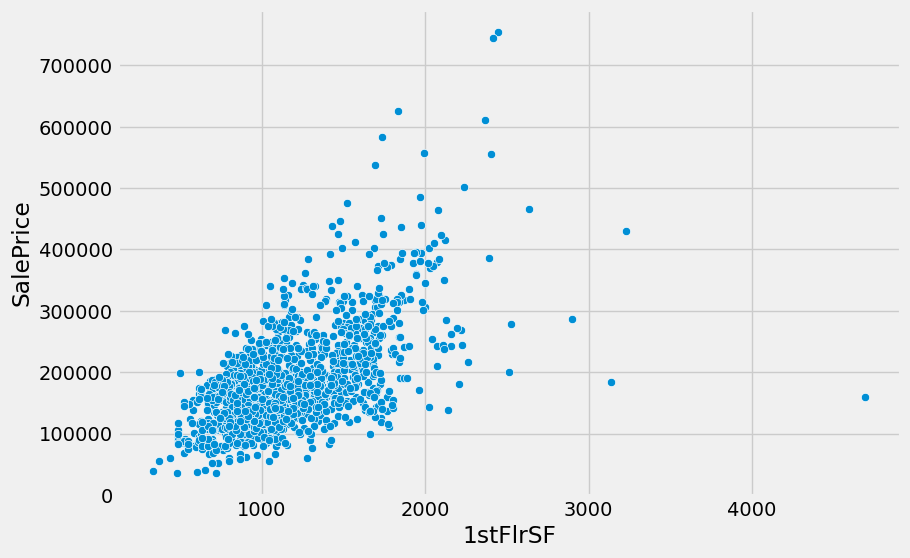

In [22]:
customized_scatterplot(train.SalePrice, train['1stFlrSF']);

How about one more...

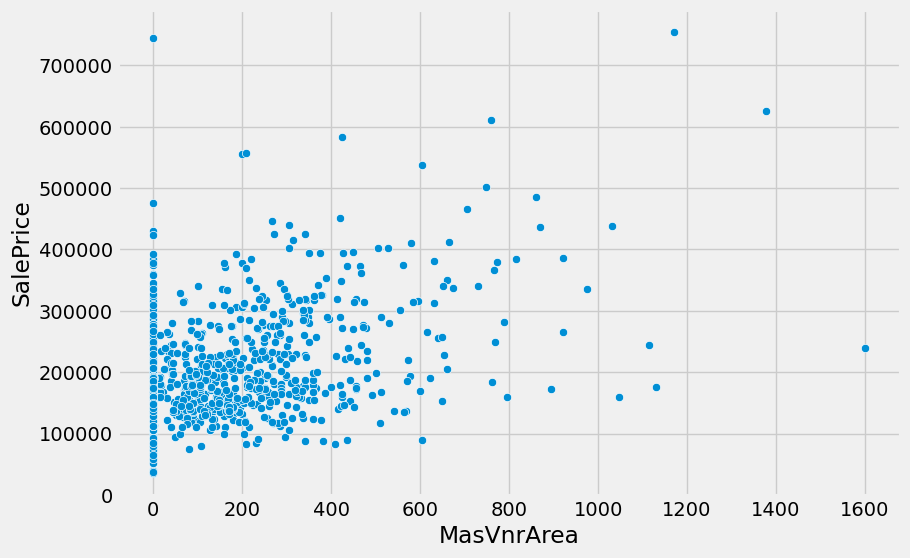

In [23]:
customized_scatterplot(train.SalePrice, train.MasVnrArea);

Okay, I think we have seen enough. Let's discuss what we have found so far. 

# Observations
* Our target variable shows an unequal level of variance across most predictor(independent) variables. This is called **Heteroscedasticity(more explanation below)** and is a red flag for the multiple linear regression model.
* There are many outliers in the scatter plots above that took my attention. 

* The two on the top-right edge of **SalePrice vs. GrLivArea** seem to follow a trend, which can be explained by saying that "As the prices increased, so did the area. 
* However, The two on the bottom right of the same chart do not follow any trends. We will get rid of these two below.

# 2. Filtering and Fine-Tuning Dataset

> Removing features with low data filling percentage

In [24]:
drop_threshold = 20 # Drop features that have more than 20% of missing data

low_data_features = missing_percentage(train)
low_data_features = low_data_features[low_data_features["Percent"] >  drop_threshold]
drop_cols = low_data_features.T.columns
print("Features to be dropped: \n{} \n{}".format(low_data_features, drop_cols))

train.drop(drop_cols, axis=1, inplace = True)

Features to be dropped: 
             Total  Percent
PoolQC        1453    99.52
MiscFeature   1406    96.30
Alley         1369    93.77
Fence         1179    80.75
FireplaceQu    690    47.26 
Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')


Checking..

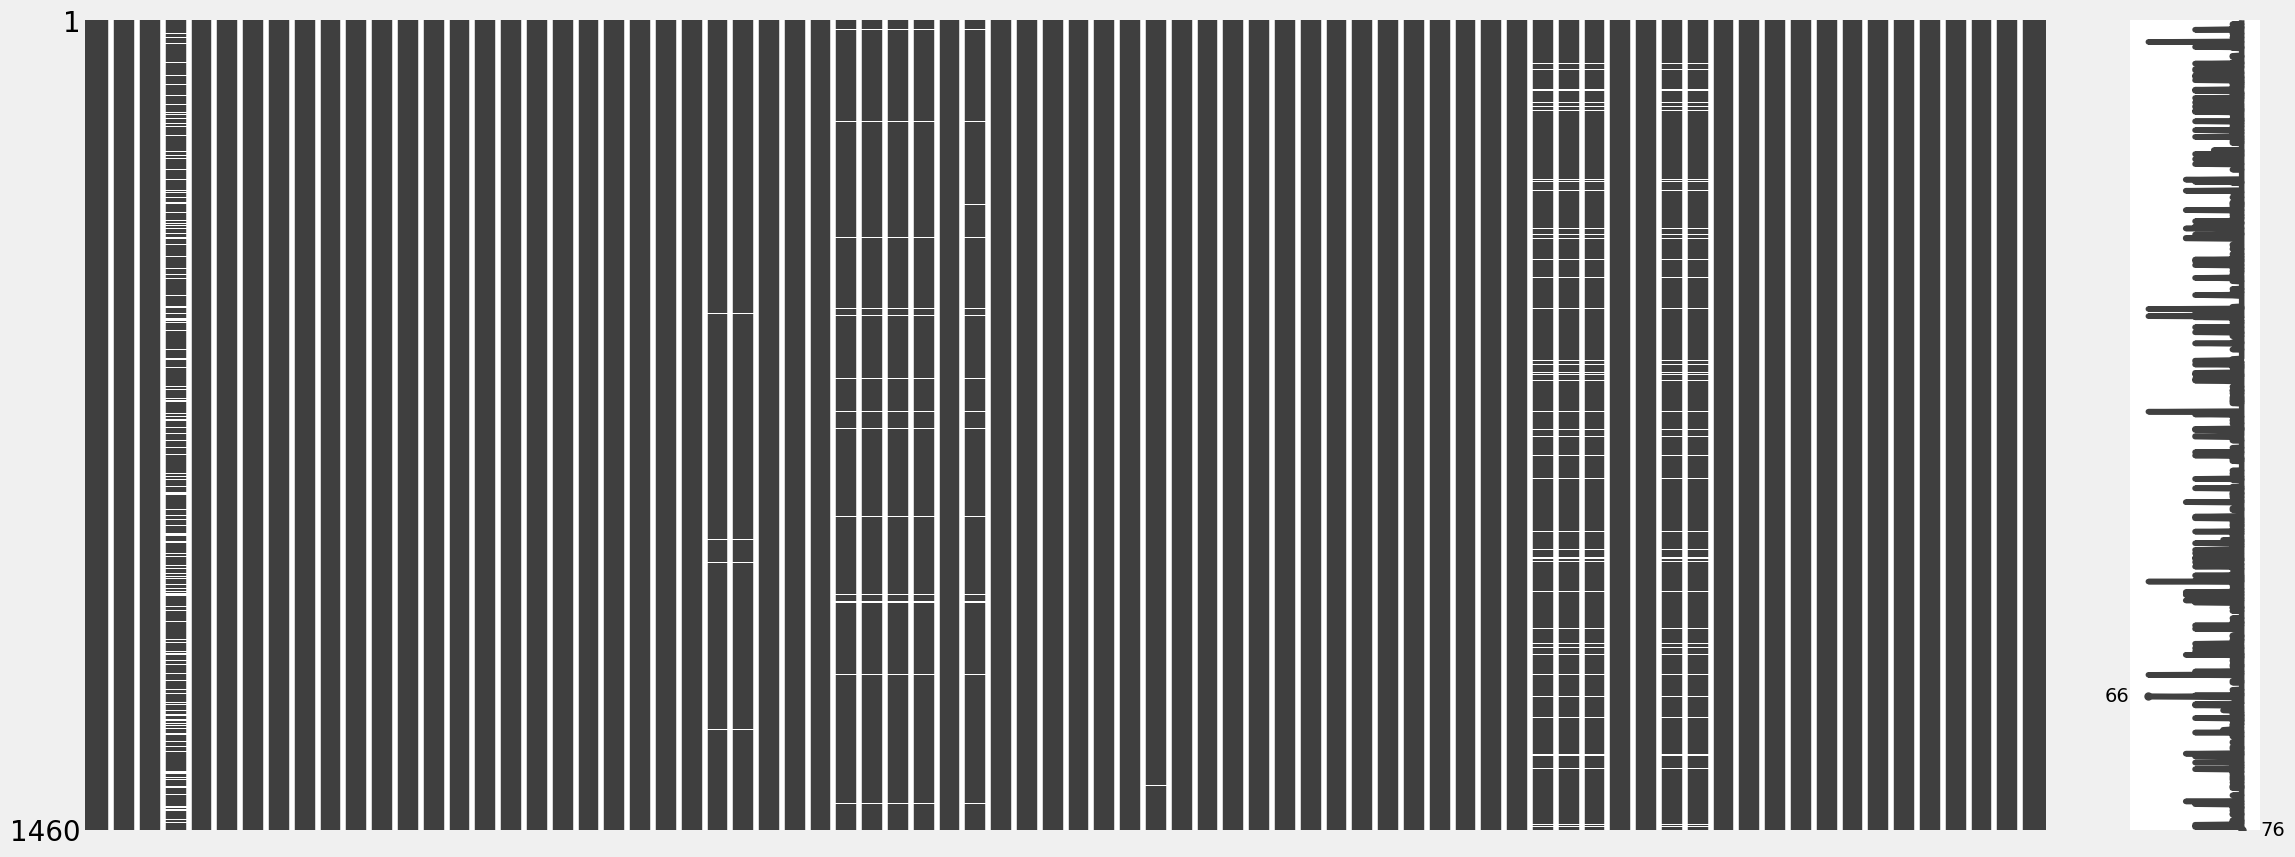

In [25]:
msno.matrix(train);

> Filling missing data

I have a lot of categorical data and therefore to not add new categories I fill with mode and not mean

In [26]:
train.mode(axis=0).dropna()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20.0,RL,60.0,7200.0,Pave,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,0.0,0.0,6.0,2009.0,WD,Normal,140000.0


In [27]:
train.isna().sum().sum()

868

In [28]:
train.fillna(train.mode().iloc[0], inplace = True)  # There is a trick to convert .mode() to DataFrame
train.isna().sum().sum()

0

Checking..

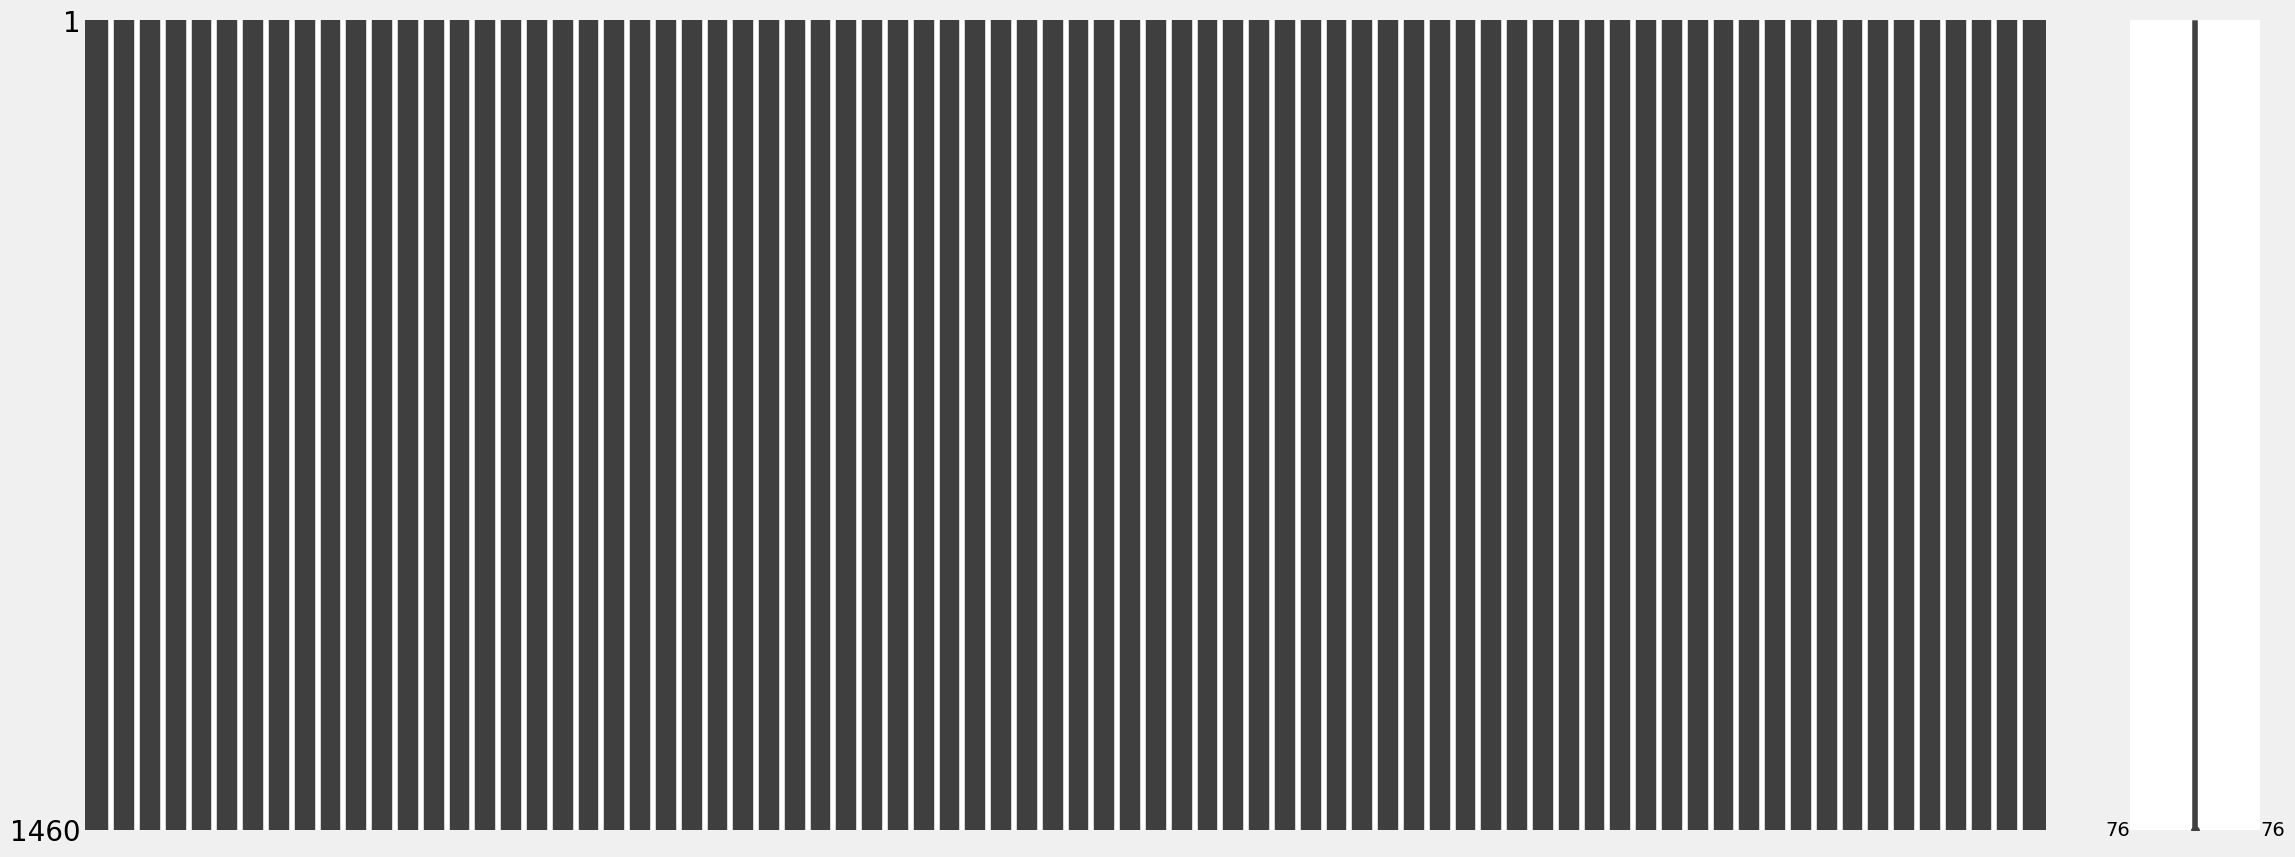

In [29]:
msno.matrix(train);

> Removing outliners

This is a complicated process as it involves a problem of outlier detection and then it can create new problems of missing values

I will apply IQR outlier detection that provides me with formula for minimum and maximum values

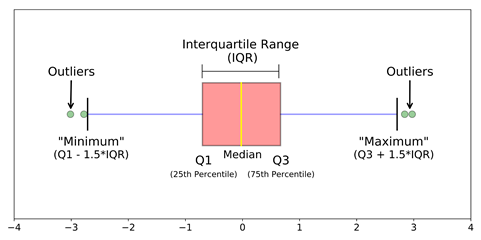

First, I will calculate how many outliers there are for each feature. If some feature has a lot of outliers it make sense to completely drop this feature as it will not brind valuable information from analysis.

Checking outliners

<Axes: >

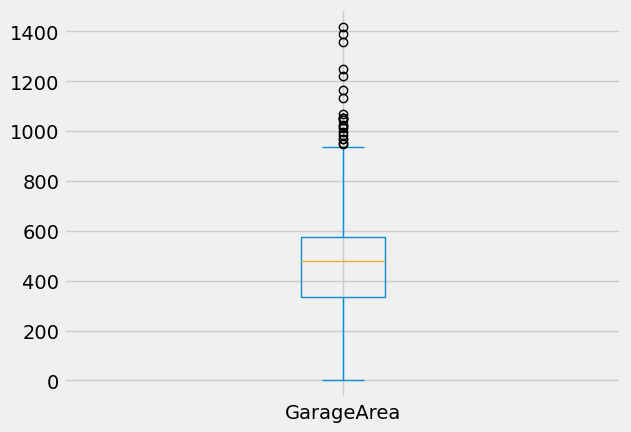

In [30]:
train["GarageArea"].plot(kind="box")

<Axes: >

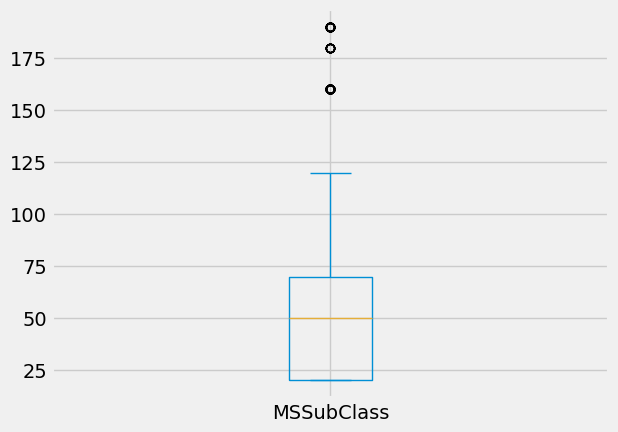

In [31]:
train["MSSubClass"].plot(kind="box")

<Axes: title={'center': 'Percentage of Outliers'}>

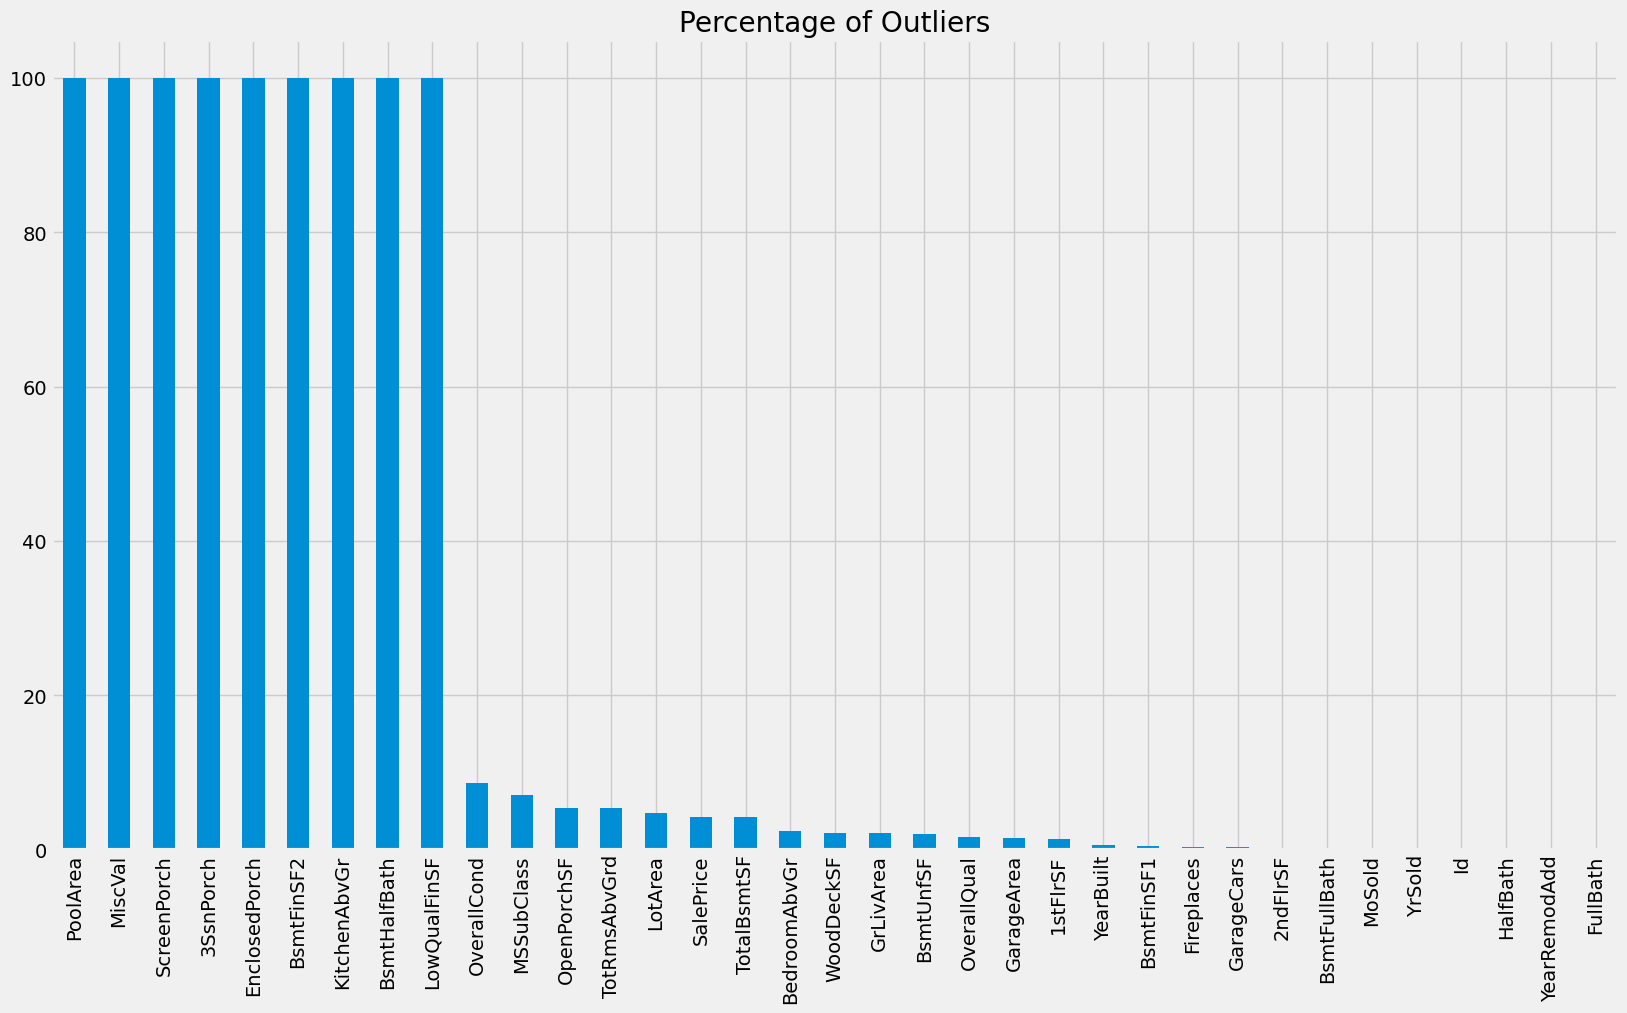

In [32]:
def count_outliers(df):
    """ Returns table feature-wise outlier count """
    out = pd.Series(index=df.columns)
    total_num = df.shape[0]
    for column in df:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lowest_val = Q1 - 1.5*IQR
        highest_val = Q3 + 1.5*IQR
        
        flter_df = df[column].copy()
        flter_df = flter_df[flter_df > lowest_val]
        flter_df = flter_df[flter_df < highest_val]

        outlier_percentage = round(100 * (total_num - flter_df.shape[0]) / total_num, 2) 
        out[column] = outlier_percentage

    return out.sort_values(ascending = False)

numerical_train = train.loc[:, train.dtypes == np.int64]
count_outliers(numerical_train).plot(kind="bar", figsize=(18, 10), title="Percentage of Outliers")

From this Bar plot it is seen that most of features have just a bit of outliers, but first 9 features have something wrong...

Let's investigate what is happening there

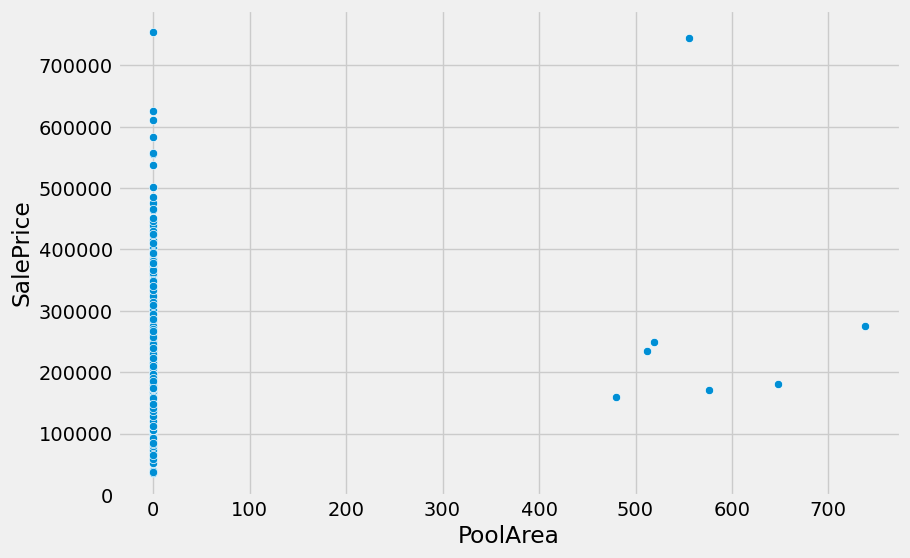

In [33]:
customized_scatterplot(train.SalePrice, train.PoolArea)

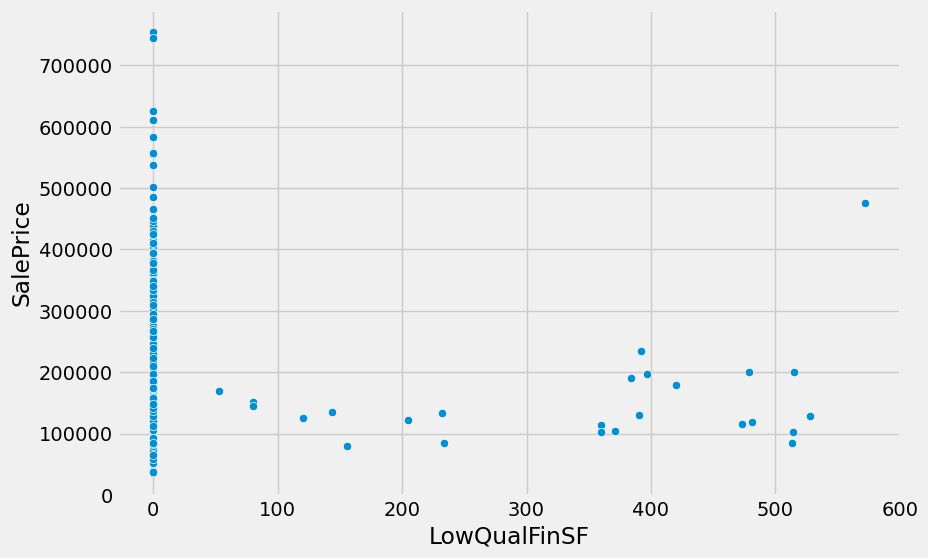

In [34]:
customized_scatterplot(train.SalePrice, train.LowQualFinSF)

Yeah, they actually have A LOT OF zero-outliers. It would be easier just to drop such features

In [35]:
drop_outliers_threshold = 50 # Drop all features that have more than 50% of outliers

outliers = count_outliers(numerical_train)
zero_outliers = outliers.index[outliers > drop_outliers_threshold]
print(zero_outliers)

train.drop(zero_outliers, axis=1, inplace=True)

Index(['PoolArea', 'MiscVal', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch',
       'BsmtFinSF2', 'KitchenAbvGr', 'BsmtHalfBath', 'LowQualFinSF'],
      dtype='object')


Checking..

(1460, 67)

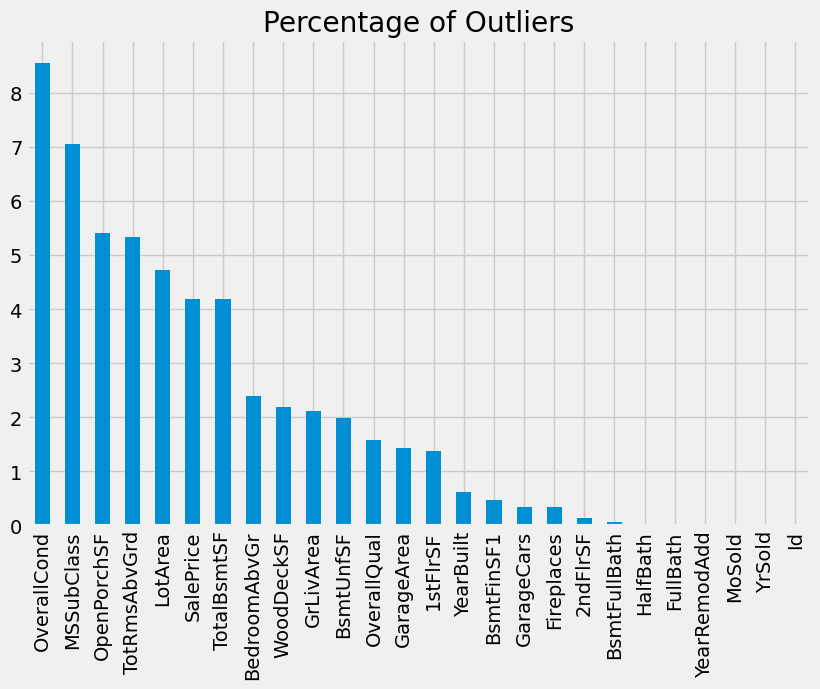

In [36]:
numerical_train = train.loc[:, train.dtypes == np.int64]
count_outliers(numerical_train).plot(kind="bar", figsize=(9, 6), title="Percentage of Outliers")
train.shape

Now I can apply IQR outlier detector and remove outliers

In [37]:
def drop_outliers(ddf, field_name):
    """ Drops outliers for specific column """
    df = ddf.copy()
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    return df

def drop_outliers_IQR(df):
    """ Drops samples that include outliers """
    for column in df:
        if df[column].dtypes != np.int64:
            continue
        df = drop_outliers(df, column)
    return df

In [38]:
train = drop_outliers_IQR(train)
print(train.shape)

(945, 67)


Checking..

<Axes: title={'center': 'Percentage of Outliers'}>

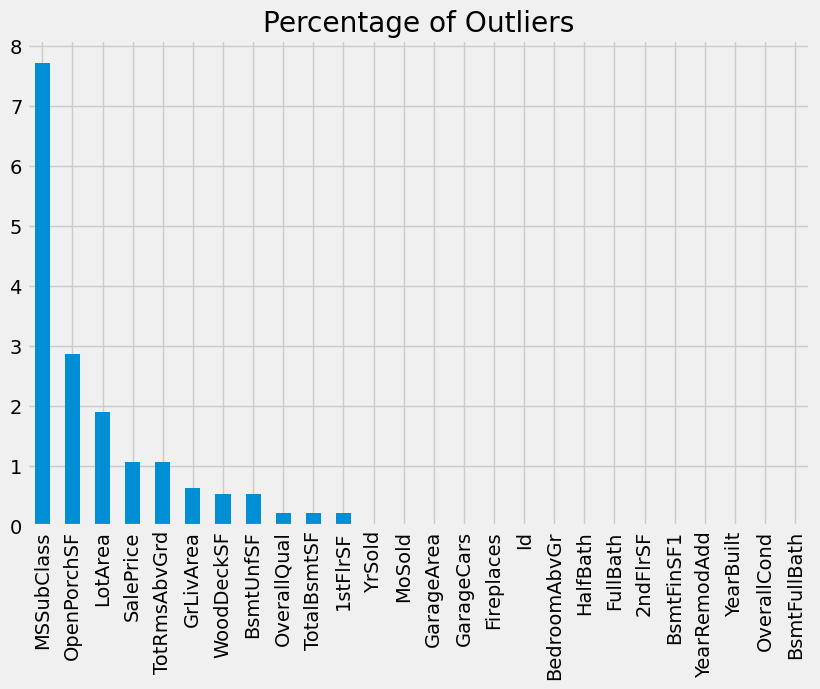

In [39]:
numerical_train = train.loc[:, train.dtypes == np.int64]
count_outliers(numerical_train).plot(kind="bar", figsize=(9, 6), title="Percentage of Outliers")

Hmmm, not all outliers dissapeared...

> ! **I tried removing outliers for features above, but eventually got stuck in creating new outliers after deleting old ones, as statistical Lowest and Highest values update after filtering. Therefore at this point outlier filtration shall stop. For visualisation I will show how outliers are not dissapearing**

(863, 67)


<Axes: title={'center': 'Percentage of Outliers'}>

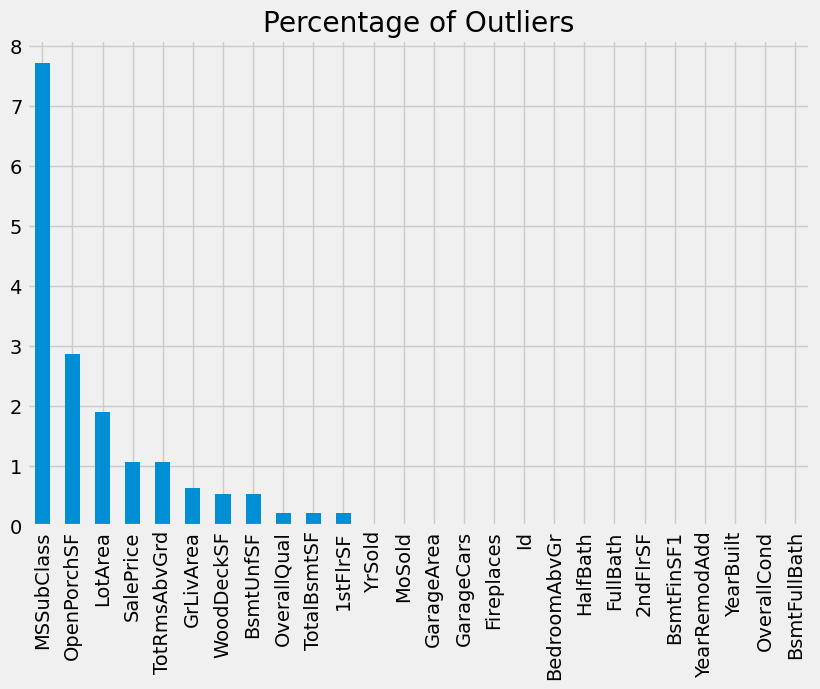

In [40]:
train_example = drop_outliers_IQR(train)
print(train_example.shape)
numerical_train = train.loc[:, train_example.dtypes == np.int64]
count_outliers(numerical_train).plot(kind="bar", figsize=(9, 6), title="Percentage of Outliers")

> Clearly I filtered some samples, the number dropped from 945 to 863! But the Figure of Outliers is the same! It shows that I have to accept some level of outliers. Otherwise I will lose a lot of data

<Axes: >

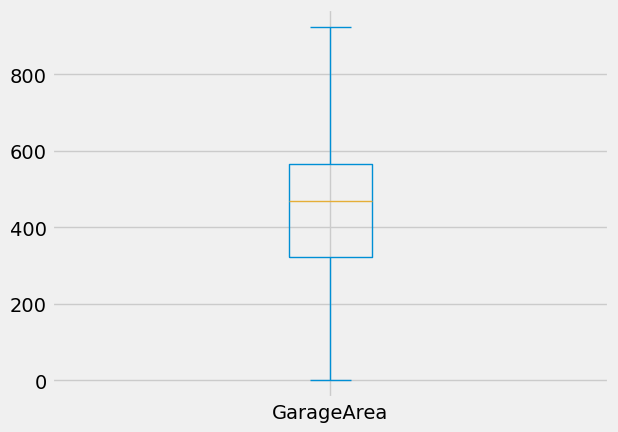

In [41]:
train["GarageArea"].plot(kind="box")

Here is a boxplot of GarageArea feature. Go up and find it before Outlier filtering. You will find that I made it clean as well as many other features!

I just want to build correlation before I apply One-Hot encoding and feature extraction with PCA

<Axes: >

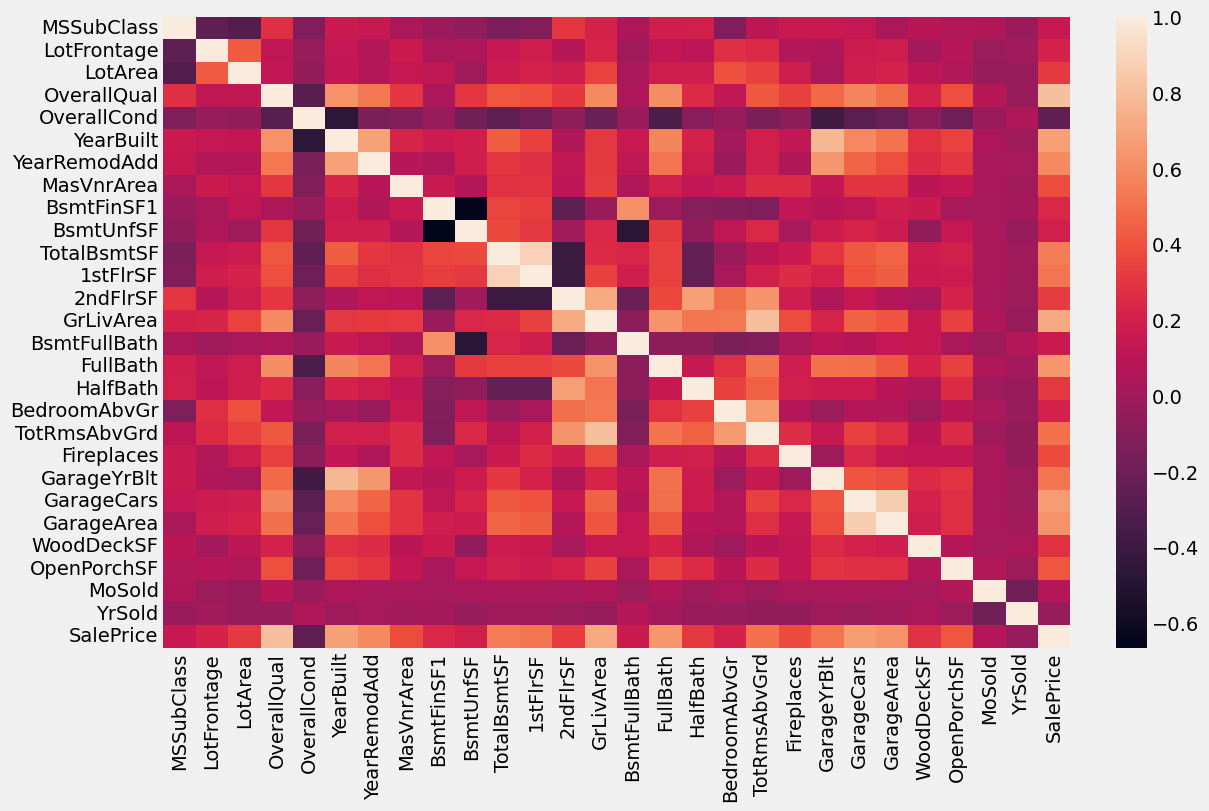

In [74]:
cor = train.corr()
plt.figure(constrained_layout=True, figsize=(12,8))
sns.heatmap(cor)

> At this point I filtered lots of features and I should remember which I dropped to do the same with testing data. 

    Next code-block makes a list of features to be dropped fro test data

In [53]:
drop_columns = set(pd.read_csv("dataset/train.csv").columns) - set(train.columns)
drop_columns.update(["Id"]) # Id is obviously unnecessary feature
print("Columns to be dropped during pre-processing: {}".format(drop_columns))

Columns to be dropped during pre-processing: {'Id', 'MiscVal', 'KitchenAbvGr', 'PoolQC', 'BsmtFinSF2', 'FireplaceQu', 'MiscFeature', 'LowQualFinSF', 'Alley', 'EnclosedPorch', 'PoolArea', 'Fence', 'ScreenPorch', '3SsnPorch', 'BsmtHalfBath'}


In [92]:
def filter_and_fill_features(df, drop_cols):
    """ Drops features with a lot of outliers or Missing Values. Fills entries with modes """
    df.drop(drop_cols, axis=1, inplace = True)
    df.fillna(df.mode().iloc[0], inplace = True) 
    df = drop_outliers_IQR(df)
    return df

In [93]:
train = pd.read_csv("dataset/train.csv")
train = filter_and_fill_features(train, drop_columns)

In [94]:
print("{} {}".format(train.shape, train.info()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945 entries, 0 to 1458
Data columns (total 66 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     945 non-null    int64  
 1   MSZoning       945 non-null    object 
 2   LotFrontage    945 non-null    float64
 3   LotArea        945 non-null    int64  
 4   Street         945 non-null    object 
 5   LotShape       945 non-null    object 
 6   LandContour    945 non-null    object 
 7   Utilities      945 non-null    object 
 8   LotConfig      945 non-null    object 
 9   LandSlope      945 non-null    object 
 10  Neighborhood   945 non-null    object 
 11  Condition1     945 non-null    object 
 12  Condition2     945 non-null    object 
 13  BldgType       945 non-null    object 
 14  HouseStyle     945 non-null    object 
 15  OverallQual    945 non-null    int64  
 16  OverallCond    945 non-null    int64  
 17  YearBuilt      945 non-null    int64  
 18  YearRemod

## One-Hot-Encoding

Encode categorical variables

There are two steps for Encoding:
- Defining which features are categorical
- Drop them and replace with One-Hot-Encoded alternatives

In [95]:
categorical_columns = train.columns[train.dtypes == "object"]
print(categorical_columns)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [150]:
def apply_categorical_encoding(dff, categorical_columns):
    """ For given list of categorical features it replaces categorical columns with encoded ste of columns """
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()

    df = dff.copy().reset_index()
    encoded_dataframe = pd.DataFrame()
    for column in categorical_columns:
        encoded_data = encoder.fit_transform(df[[column]]).toarray()
        encoded_df = pd.DataFrame(encoded_data, columns=['{}_'.format(column) + x for x in encoder.categories_[0]])
        encoded_dataframe = pd.concat([encoded_dataframe, encoded_df], axis=1)
        
    df.drop(categorical_columns, axis=1, inplace=True)
    df = pd.concat([df, encoded_dataframe], axis=1)
    return df

In [151]:
print("Before encoding: {}".format(train.shape))
enc_train = apply_categorical_encoding(train, categorical_columns)
print("After encoding: {}".format(enc_train.shape))

Before encoding: (945, 66)
encoded_dataframe:  (945, 211)
(945, 67)
(945, 29)
(945, 240)
After encoding: (945, 240)


## Feature Extraction

Now it is time to reduce number of features to make training easier

Currently, dataset has next 

In [91]:
print(enc_train.shape)

(1267, 239)


## Scaling

Data normalization

# Modeling


create a model and fit data to it

# Feature engineering

In [ ]:
## Dropping the "Id" from train and test set. 
# train.drop(columns=['Id'],axis=1, inplace=True)

train.drop(columns=['Id'],axis=1, inplace=True)
test.drop(columns=['Id'],axis=1, inplace=True)

## Saving the target values in "y_train". 
y = train['SalePrice'].reset_index(drop=True)



# getting a copy of train
previous_train = train.copy()

In [ ]:
# quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
# qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

# def encode(df, feature, target_feature):
#     """
#     This function takes a dataframe, a feature(a categorical feature) and a target_feature(the feature that should be used for encoding)
#     and returns a new feature with the original feature name + postfix(_E). 
#     This new feature consists of encoded value of unique original value but the values are weighted(incremented) based on the 
#     mean of target_feature and grouped by the feature itself.
#     """
#     ordering = pd.DataFrame()
#     ordering['val'] = df[feature].unique()
#     ordering.index = ordering.val
#     ordering['spmean'] = df[[feature, target_feature]].groupby(feature).mean()[target_feature]
#     ordering = ordering.sort_values('spmean')
#     ordering['ordering'] = range(1, ordering.shape[0]+1)
#     ordering = ordering['ordering'].to_dict()
    
#     for cat, o in ordering.items():
#         df.loc[df[feature] == cat, feature+'_E'] = o
    
# qual_encoded = []
# for q in qualitative:  
#     encode(train, q, 'SalePrice')
#     qual_encoded.append(q+'_E')
# print(qual_encoded)

In [ ]:
## Combining train and test datasets together so that we can do all the work at once. 
all_data = pd.concat((train, test)).reset_index(drop = True)
## Dropping the target variable. 
all_data.drop(['SalePrice'], axis = 1, inplace = True)

## Dealing with Missing Values
> **Missing data in train and test data(all_data)**

In [ ]:
missing_percentage(all_data)

> **Imputing Missing Values**

In [ ]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [ ]:
## In the following features the null values are there for a purpose, so we replace them with "0"
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)
    
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [ ]:
## the "OverallCond" and "OverallQual" of the house. 
# all_data['OverallCond'] = all_data['OverallCond'].astype(str) 
# all_data['OverallQual'] = all_data['OverallQual'].astype(str)

## Zoning class are given in numerical; therefore converted to categorical variables. 
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

## Important years and months that should be categorical variables not numerical. 
# all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
# all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
# all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str) 

In [ ]:
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 


In [ ]:
missing_percentage(all_data)

So, there are no missing value left. 

## Fixing Skewness

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_feats

In [ ]:
sns.distplot(all_data['1stFlrSF']);

In [ ]:
## Fixing Skewed features using boxcox transformation. 


def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

fixing_skewness(all_data)

In [ ]:
sns.distplot(all_data['1stFlrSF']);

## Creating New Features

In [ ]:
# feture engineering a new feature "TotalFS"
all_data['TotalSF'] = (all_data['TotalBsmtSF'] 
                       + all_data['1stFlrSF'] 
                       + all_data['2ndFlrSF'])

all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] 
                                 + all_data['BsmtFinSF2'] 
                                 + all_data['1stFlrSF'] 
                                 + all_data['2ndFlrSF']
                                )
                                 

all_data['Total_Bathrooms'] = (all_data['FullBath'] 
                               + (0.5 * all_data['HalfBath']) 
                               + all_data['BsmtFullBath'] 
                               + (0.5 * all_data['BsmtHalfBath'])
                              )
                               

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] 
                              + all_data['3SsnPorch'] 
                              + all_data['EnclosedPorch'] 
                              + all_data['ScreenPorch'] 
                              + all_data['WoodDeckSF']
                             )
                              
                              


In [ ]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
all_data.shape

## Deleting features

In [ ]:
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

## Creating Dummy Variables. 


In [ ]:
## Creating dummy variable 
final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

In [ ]:
X = final_features.iloc[:len(y), :]

X_sub = final_features.iloc[len(y):, :]

In [ ]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [ ]:
counts = X.BsmtUnfSF.value_counts()

In [ ]:
counts.iloc[0]

In [ ]:
for i in X.columns:
    counts = X[i].value_counts()
    print (counts)

In [ ]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(X)

X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

In [ ]:
X.shape,y.shape, X_sub.shape

# Fitting model(simple approach)

## Train_test split
 
We have separated dependent and independent features; We have separated train and test data. So, why do we still have to split our training data? If you are curious about that, I have the answer. For this competition, when we train the machine learning algorithms, we use part of the training set, usually two-thirds of the train data. Once we train our algorithm using 2/3 of the train data, we start to test our algorithms using the remaining data. If the model performs well, we dump our test data in the algorithms to predict and submit the competition. The code below, basically splits the train data into 4 parts, <b>X_train, X_test, y_train, y_test.</b>
* <b>X_train, y_train</b> first used to train the algorithm. 
* then, **X_test** is used in that trained algorithms to predict **outcomes. **
* Once we get the **outcomes**, we compare it with **y_test**

By comparing the **outcome** of the model with **test_y**, we can determine whether our algorithms are performing well or not. Once we are confident about the result of our algorithm, we may use the model to on the original test data and submit in the challenge. I have tried to show this whole process in the visualization chart below.

In [ ]:
## Train test s
from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Modeling the Data
 
Before modeling each algorithm, I would like to discuss them for a better understanding. This way I would review what I know and at the same time help out the community. If you already know enough about Linear Regression, you may skip this part and go straight to the part where I fit the model. However, if you take your time to read this and other model description sections and let me know how I am doing, I would genuinely appreciate it. Let's get started. 

**Linear Regression**
<div>
    We will start with one of the most basic but useful machine learning model, **Linear Regression**. However, do not let the simplicity of this model fool you, as Linear Regression is the base some of the most complex models out there. For the sake of understanding this model, we will use only two features, **SalePrice** and **GrLivArea**. Let's take a sample of the data and graph it.

In [ ]:
sample_train = previous_train.sample(300)
import seaborn as sns
plt.subplots(figsize = (15,8))
ax = plt.gca()
ax.scatter(sample_train.GrLivArea.values, sample_train.SalePrice.values, color ='b');
plt.title("Chart with Data Points");
#ax = sns.regplot(sample_train.GrLivArea.values, sample_train.SalePrice.values)
#ax.plot((sample_train.GrLivArea.values.min(),sample_train.GrLivArea.values.max()), (sample_train.SalePrice.values.mean(),sample_train.SalePrice.values.mean()), color = 'r');

As we discussed before, there is a linear relationship between SalePrice and GrLivArea. We want to know/estimate/predict the sale price of a house based on the given area, How do we do that? One naive way is to find the average of all the house prices. Let's find a line with the average of all houses and place it in the scatter plot. Simple enough.

In [ ]:
plt.subplots(figsize = (15,8))
ax = plt.gca()
ax.scatter(sample_train.GrLivArea.values, sample_train.SalePrice.values, color ='b');
#ax = sns.regplot(sample_train.GrLivArea.values, sample_train.SalePrice.values)
ax.plot((sample_train.GrLivArea.values.min(),sample_train.GrLivArea.values.max()), (sample_train.SalePrice.values.mean(),sample_train.SalePrice.values.mean()), color = 'r');
plt.title("Chart with Average Line");

You can tell this is not the most efficient way to estimate the price of houses. The average line clearly does not represent all the datapoint and fails to grasp the linear relationship between <b>GrLivArea & SalePrice. </b> Let use one of the evaluation regression metrics and find out the Mean Squared Error(more on this later) of this line.

In [ ]:
## Calculating Mean Squared Error(MSE)
sample_train['mean_sale_price'] = sample_train.SalePrice.mean()
sample_train['mse'] = np.square(sample_train.mean_sale_price - sample_train.SalePrice)
sample_train.mse.mean()
## getting mse
print("Mean Squared Error(MSE) for average line is : {}".format(sample_train.mse.mean()))

> If you are reading this in my github page, you may find it difficult to follow through as the following section includes mathematical equation. Please checkout [this](https://www.kaggle.com/masumrumi/a-stats-analysis-and-ml-workflow-of-house-pricing) kernel at Kaggle. 

We will explain more on MSE later. For now, let's just say, the closer the value of MSE is to "0", the better. Of course, it makes sense since we are talking about an error(mean squared error). We want to minimize this error. How can we do that? 

Introducing **Linear Regression**, one of the most basic and straightforward models. Many of us may have learned to show the relationship between two variable using something called "y equals mX plus b." Let's refresh our memory and call upon on that equation.



# $$ {y} = mX + b $$



Here, 
* **m** = slope of the regression line. It represents the relationship between X and y. In another word, it gives weight as to for each x(horizontal space) how much y(vertical space) we have to cover. In machine learning, we call it **coefficient**. 
* **b** = y-intercept. 
* **x** and **y** are the data points located in x_axis and y_axis respectively. 


<br/>

If you would like to know more about this equation, Please check out this [video](https://www.khanacademy.org/math/algebra/two-var-linear-equations/writing-slope-intercept-equations/v/graphs-using-slope-intercept-form). 

This slope equation gives us an exact linear relationship between X and y. This relationship is "exact" because we are given X and y beforehand and based on the value of X and y, we come up with the slope and y-intercept, which in turns determine the relationship between X and y. However, in real life, data is not that simple. Often the relationship is unknown to us, and even if we know the relationship, it may not always be exact. To fit an exact slope equation in an inexact relationship of data we introduce the term error. Let's see how mathematicians express this error with the slope equation. 

## $$ y = \beta_0 + \beta_1 x + \epsilon \\ $$

And, this is the equation for a simple linear regression.
Here,
* y = Dependent variable. This is what we are trying to estimate/solve/understand. 
* $\beta_0$ = the y-intercept, it is a constant and it represents the value of y when x is 0. 
* $\beta_1$ = Slope, Weight, Coefficient of x. This metrics is the relationship between y and x. In simple terms, it shows 1 unit increase in y changes when 1 unit increases in x. 
* $x_1$ = Independent variable ( simple linear regression ) /variables.
* $ \epsilon$ = error or residual. 

### $$ \text{residual}_i = y_i - \hat{y}_i$$
This error is the only part that's different/addition from the slope equation. This error exists because in real life we will never have a dataset where the regression line crosses exactly every single data point. There will be at least a good amount of points where the regression line will not be able to go through for the sake of model specifications and ** bias-variance tradeoff **(more on this later). This error term accounts for the difference of those points. So, simply speaking, an error is the difference between an original value( $y_i$ ) and a predicted value( $\hat{y}_i$ ). 

We use this function to predict the values of one dependent(target) variable based on one independent(predictor) variable. Therefore this regression is called **Simple linear regression(SLR).** If we were to write the equation regarding the sample example above it would simply look like the following equation, 
## $$ Sale Price= \beta_0 + \beta_1 (Area) + \epsilon \\ $$

This equation gives us a line that fits the data and often performs better than the average line above. But,
* How do we know that Linear regression line is actually performing better than the average line? 
* What metrics can we use to answer that? 
* How do we know if this line is even the best line(best-fit line) for the dataset? 
* If we want to get even more clear on this we may start with answering, How do we find the $\beta_0$(intercept) and  $\beta_1$(coefficient) of the equation?

<b>Finding $\beta_0$(intercept) and  $\beta_1$(coefficient):</b>

We can use the following equation to find the $\beta_0$(intercept) and  $\beta_1$(coefficient)


### $$ \hat{\beta}_1 = r_{xy} \frac{s_y}{s_x}$$
### $$ \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x} $$

Here...
- $\bar{y}$ : the sample mean of observed values $Y$
- $\bar{x}$ : the sample mean of observed values $X$
- $s_y$ : the sample standard deviation of observed values $Y$
- $s_x$ : the sample standard deviation of observed values $X$

    > There are two types of STD's. one is for sample population and one is for Total population.
    > Check out [this](https://statistics.laerd.com/statistical-guides/measures-of-spread-standard-deviation.php) article for more. 

- $r_{xy}$ : the sample Pearson correlation coefficient between observed $X$ and $Y$


I hope most of us know how to calculate all these components from the two equations above by hand. I am going to only mention the equation of the pearson correlation(r_xy) here as it may be unknown to some of the readers. 

### $$ r_{xy}= \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum(x_i - \bar{x})^2{\sum(y_i - \bar{y})^2}}}$$

Let's get on with calculating the rest by coding.

In [ ]:
## Calculating the beta coefficients by hand. 
## mean of y. 
y_bar = sample_train.SalePrice.mean()
## mean of x. 
x_bar = sample_train.GrLivArea.mean()
## Std of y
std_y = sample_train.SalePrice.std()
## std of x
std_x = sample_train.GrLivArea.std()
## correlation of x and y
r_xy = sample_train.corr().loc['GrLivArea','SalePrice']
## finding beta_1
beta_1 = r_xy*(std_y/std_x)
## finding beta_0
beta_0 = y_bar - beta_1*x_bar

So, we have calculated the beta coefficients.  We can now plug them in the linear equation to get the predicted y value. Let's do that.

In [ ]:
## getting y_hat, which is the predicted y values. 
sample_train['Linear_Yhat'] = beta_0 + beta_1*sample_train['GrLivArea']

Now that we have our predicted y values let's see how the predicted regression line looks in the graph.

In [ ]:
# create a figure
fig = plt.figure(figsize=(15,7))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(sample_train.GrLivArea, sample_train.SalePrice, c='b')
ax.plot(sample_train['GrLivArea'], sample_train['Linear_Yhat'], color='r');

Phew!! This looks like something we can work with!! Let's find out the MSE for the regression line as well.

In [ ]:
## getting mse
print("Mean Squared Error(MSE) for regression line is : {}".format(np.square(sample_train['SalePrice'] - sample_train['Linear_Yhat']).mean()))

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(sample_train['SalePrice'], sample_train.Linear_Yhat)

A much-anticipated decrease in mean squared error(mse), therefore better-predicted model. The way we compare between the two predicted lines is by considering their errors. Let's put both of the model's side by side and compare the errors.

In [ ]:
## Creating a customized chart. and giving in figsize and everything. 
fig = plt.figure(constrained_layout=True, figsize=(15,5))
## creating a grid of 3 cols and 3 rows. 
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
#gs = fig3.add_gridspec(3, 3)
#ax1 = fig.add_subplot(grid[row, column])
ax1 = fig.add_subplot(grid[0, :1])

# get the axis
ax1 = fig.gca()

# plot it
ax1.scatter(x=sample_train['GrLivArea'], y=sample_train['SalePrice'], c='b')
ax1.plot(sample_train['GrLivArea'], sample_train['mean_sale_price'], color='k');

# iterate over predictions
for _, row in sample_train.iterrows():
    plt.plot((row['GrLivArea'], row['GrLivArea']), (row['SalePrice'], row['mean_sale_price']), 'r-')
    
ax2 = fig.add_subplot(grid[0, 1:])

# plot it
ax2.scatter(x=sample_train['GrLivArea'], y=sample_train['SalePrice'], c='b')
ax2.plot(sample_train['GrLivArea'], sample_train['Linear_Yhat'], color='k');
# iterate over predictions
for _, row in sample_train.iterrows():
    plt.plot((row['GrLivArea'], row['GrLivArea']), (row['SalePrice'], row['Linear_Yhat']), 'r-')

On the two charts above, the left one is the average line, and the right one is the regression line. <font color="blue"><b>Blue</b></font> dots are observed data points and <font color="red"><b>red</b></font> lines are error distance from each observed data points to model-predicted line. As you can see, the regression line reduces much of the errors; therefore, performs much better than average line. 

Now, we need to introduce a couple of evaluation metrics that will help us compare and contrast models. One of them is mean squared error(MSE) which we used while comparing two models. Some of the other metrics are...

* RMSE (Root Mean Squared Error)
### $$ \operatorname{RMSE}= \sqrt{\frac{1}{n}\sum_{i=1}^n(\hat{y_i} - y_i)^2} $$

Here
* $y_i$ = Each observed data point. 
* $\bar{y}$ = Mean of y value.
* $\hat{y_i}$ = Predicted data point for each $x_i$ depending on i. 


* MSE(Mean Squared Error)
### $$\operatorname{MSE}= \frac{1}{n}\sum_{i=1}^n(\hat{y_i} - y_i)^2$$

* MAE (Mean Absolute Error)
### $$\operatorname{MAE} = \frac{\sum_{i=1}^n|{\bar{y} - y_i}|}{n}$$

* RSE (Relative Squared Error)
### $$\operatorname{RSE}= \frac{\sum_{i=1}^n(\hat{y_i} - y_i)^2}{\sum_{i=1}^n(\bar{y} - y_i)^2}$$

* RAE (Relative Absolute Error) 
### $$\operatorname{RAE}= \frac{\sum_{i=1}^n |\hat{y_i} - y_i|}{\sum_{i=1}^n |\bar{y} - y_i|}$$

> and 
* $R^2$ (Coefficient of the determination)



The evaluation metrics often named in such a way that I find it confusing to remember. So, this is a guide for me and everyone else who is reading it. There are many evaluation metrics. Let's name a few of them. 

It may seem confusing with multiple similar abbreviations, but once we focus on what they each do, things will become much more intuitive. For now, I am going to dive right into the $R^2$.

# $R^2$(The "Coefficient of determination"): 
> $R^2$ describes the proportion of variance of the dependent variable explained by the regression model. Let's write the equation for $R^2$. 

# $$ \operatorname{R^2} = \frac{SSR}{SST} $$

Here,

* SST(Sum of the Total Squared Error) is the total residual. It is also known as TSS(Total Sum of the Squared Error)
* SSR(Sum of the Squared Regression) is the residual explained by the regression line. SSR is also known as ESS(Explained Sum of the Squared Error)

and

* SSE(Sum of the Squared Error)/RSS(Residual Sum of the Squared Error)
Let's break these down. 

## SST/TSS:
SST is the sum of the squared distance from all points to average line ( $\bar{y}$ ). We call this the **total variation** in the Y's of the **Total Sum of the Squares(SST).** Let's see it in the function. 
### $$ \operatorname{SST} = \sum_{i=1}^n \left(y_i - \bar{y}\right)^2 $$

Here
* $y_i$ = Each observed data point. 
* $\bar{y}$ = Mean of y value.
* $\hat{y_i}$ = Predicted data point for each $x_i$ depending on i. 

A visualization would make things much more clear.
![](http://blog.hackerearth.com/wp-content/uploads/2016/12/anat.png)
 
In this visualization above, the light green line is the <font color="green"><b>average line</b></font> and the black dot is the observed value. So, SST describes the distance between the black dot and the <font color="green"><b>average line</b></font>.


## SSR/ESS:
SSR is the sum of the squared residual between each predicted value and the average line. In statistics language we say that, SSR is the squared residual explained by the regression line. In the visualization above SSR is the distance from <font color='green'><b>baseline model</b></font> to the <font color = 'blue'><b>regression line.</b></font> 
### $$ SSR = \sum_{i=1}^n \left(\hat{y_i} - \bar{y}\right)^2 $$

## SSE/RSS: 
RSS is calculated by squaring each residual of the data points and then adding them together. This residual is the difference between the predicted line and the observed value. In statistics language, we say, SSE is the squared residual that was not explained by the regression line, and this is the quantity least-square minimizes. In the chart above SSE is the distance of the actual data point from the <font color = 'blue'><b>regression line</b></font>. 

### $$ SSE = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 $$

And the relation between all three of these metrics is
## $$SST = SSR + SSE$$


From the equation above and the $R^2$ equation from the top we can modify the $R^2$ equation as the following
# $$ R^2 = 1 - \frac{SSE}{SST} $$

## More on $R^2$: 
* $R^2$ is matric with a value between 0 and 1. 
* If the points are perfectly linear, then error sum of squares is 0, In that case, SSR = SST. Which means the variation in the Y's is completely explained by the regression line causing the value of $R^2$ to be close to 1. 
* In other extreme cases, when there is no relation between x and y, hence SSR = 0 and therefore SSE = SST, The regression line explains none of the variances in Y causing $R^2$ to be close to 0.
* $R^2$ measures the explanatory power of the model; The more of the variance in the dependent variable(Y) the model can explain, the more powerful it is.
* $R^2$ can be infinitely negative as well. Having a negative indicates that the predictive equation has a greater error than the baseline model.
* The value of $R^2$ increases as more feature gets added despite the effectiveness of those features in the model.
* This is a problem, since we may think that having a greater $R^2$ means a better model, even though the model didnot actually improved. In order to get around this we use Adjusted R-Squared($R^2_{adj}$)

**Adjusted R-Squared($R^2_{adj}$)**: 

$R^2_{adj}$ is similar to $R^2$. However, the value of$R^2_{adj}$ decreases if we use a feature that doesn't improve the model significantly. Let's write the equation for $R^2_{adj}$. 

## $$ {R^2_{adj}} = 1 - [\frac{(1 - R^2)(n-1)}{(n-k-1)}]$$

here, 
* n = # of datapoints. 
* k = # of feature used. 

As you can see from the equation, the increase of k(feature) in the denumerator penilizes the adjusted $R^2$ value if there is not a significant improvement of $R^2$ in the numerator.  

### The following part is a work in progress!!

So, from the Evaluation section above, we know that, 
### $$ RSS = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 $$

And, we already know ...
## $$ \hat{y} = \beta_0 + \beta_1 x + \epsilon \\ $$

Let's plug in( $\hat{Y}$  ) equation in the RSS equation and we get...
$$RSS = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 $$

This equation is also known as the loss function. Here, **"loss"** is the sum of squared residuals(More on this later). 

### Mean Squared Error
Now let's get back to our naive prediction and calculate the **Mean squared error**, which is also a metrics similar to RSS, helps us determine how well our model is performing. In **Mean squared error** we subtract the mean of y from each y datapoints and square them. 


If you would like to improve this result further, you can think about the assumptions of the linear regressions and apply them as we have discussed earlier in this kernel. 


Similar to **Simple Linear Regression**, there is an equation for multiple independent variables to predict a target variable. The equation is as follows.

## $$ \hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $$

Here, We already know parts of the equation, and from there we can keep adding new features and their coefficients with the equations. Quite simple, isn't it. 

We can have a target variable predicted by multiple independent variables using this equation. Therefore this equation is called **Multiple Linear Regression.** Let's try this regression in the housing dataset.


In [ ]:
## importing necessary models.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)
## fit train and test data. 
lin_reg.fit(X_train, y_train)
## Predict test data. 
y_pred = lin_reg.predict(X_test)

In [ ]:
## get average squared error(MSE) by comparing predicted values with real values. 
print ('%.2f'%mean_squared_error(y_test, y_pred))

## Using cross validation.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
lin_reg = LinearRegression()
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, X,y,cv = cv, scoring = 'neg_mean_absolute_error')

In [ ]:
print ('%.8f'%scores.mean())

 This way of model fitting above is probably the simplest way to construct a machine learning model. However, Let's dive deep into some more complex regression. 

### Regularization Models
What makes regression model more effective is its ability of *regularizing*. The term "regularizing" stands for models ability **to structurally prevent overfitting by imposing a penalty on the coefficients.** 


There are three types of regularizations. 
* **Ridge**
* **Lasso**
* **Elastic Net**

These regularization methods work by penalizing **the magnitude of the coefficients of features** and at the same time **minimizing the error between the predicted value and actual observed values**.  This minimization becomes a balance between the error (the difference between the predicted value and observed value) and the size of the coefficients. The only difference between Ridge and Lasso is **the way they penalize the coefficients.** Elastic Net is the combination of these two. **Elastic Net** adds both the sum of the squares errors and the absolute value of the squared error. To get more in-depth of it, let us review the least squared loss function. 

**Ordinary least squared** loss function minimizes the residual sum of the square(RSS) to fit the data:

### $$ \text{minimize:}\; RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 $$

Let's review this equation once again, Here: 
* $y_i$ is the observed value. 
* $\hat{y}_i$ is the predicted value. 
* The error = $y_i$ - $\hat{y}_i$
* The square of the error = $(y_i - \hat{y}_i)^2$
* The sum of the square of the error = $\sum_{i=1}^n (y_i - \hat{y}_i)^2$, that's the equation on the left. 
* The only difference between left sides equation vs. the right sides one above is the replacement of $\hat{y}_i$, it is replaced by $\left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)$, which simply follow's the slope equation, y = mx+b, where, 
* $\beta_0$ is the intercept. 
* **$\beta_j$ is the coefficient of the feature($x_j$).**

Let's describe the effect of regularization and then we will learn how we can use loss function in Ridge.
* One of the benefits of regularization is that it deals with **multicollinearity**(high correlation between predictor variables) well, especially Ridge method. Lasso deals with **multicollinearity** more brutally by penalizing related coefficients and force them to become zero, hence removing them. However, **Lasso** is well suited for redundant variables. 
 
***
<div>
    
 ### Ridge:
Ridge regression adds penalty equivalent to the square of the magnitude of the coefficients. This penalty is added to the least square loss function above and looks like this...

### $$ \text{minimize:}\; RSS+Ridge = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_2\sum_{j=1}^p \beta_j^2$$

Here, 
* $\lambda_2$ is constant; a regularization parameter. It is also known as $\alpha$. The higher the value of this constant the more the impact in the loss function. 
    * When $\lambda_2$ is 0, the loss funciton becomes same as simple linear regression. 
    * When $\lambda_2$ is $\infty$, the coefficients become 0
    * When $\lambda_2$ is between  0 and $\infty$(0<$\lambda_2$<$\infty$), The $\lambda_2$ parameter will decide the miagnitude given to the coefficients. The coefficients will be somewhere between 0 and ones for simple linear regression. 
* $\sum_{j=1}^p \beta_j^2$, is the squared sum of all coefficients. 

Now that we know every nitty-gritty details about this equation, let's use it for science, but before that a couple of things to remember. 
* It is essential to standardize the predictor variables before constructing the models. 
* It is important to check for multicollinearity,

In [ ]:
## Importing Ridge. 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
## Assiging different sets of alpha values to explore which can be the best fit for the model. 
alpha_ridge = [-3,-2,-1,1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    ridge = Ridge(alpha= i, normalize=True)
    ## fit the model. 
    ridge.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = ridge.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [ ]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

In [ ]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

### Lasso:
Lasso adds penalty equivalent to the absolute value of the sum of coefficients. This penalty is added to the least square loss function and replaces the squared sum of coefficients from Ridge. 

## $$ \text{minimize:}\; RSS + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j|$$

Here, 
* $\lambda_2$ is a constant similar to the Ridge function. 
* $\sum_{j=1}^p |\beta_j|$ is the absolute sum of the coefficients.

In [ ]:
from sklearn.linear_model import Lasso 
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    lasso_reg = Lasso(alpha= i, normalize=True)
    ## fit the model. 
    lasso_reg.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [ ]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

In [ ]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

### Elastic Net: 
Elastic Net is the combination of both Ridge and Lasso. It adds both the sum of squared coefficients and the absolute sum of the coefficients with the ordinary least square function. Let's look at the function. 

### $$ \text{minimize:}\; RSS + Ridge + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j| + \lambda_2\sum_{j=1}^p \beta_j^2$$

This equation is pretty self-explanatory if you have been following this kernel so far.

In [ ]:
from sklearn.linear_model import ElasticNet
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    lasso_reg = ElasticNet(alpha= i, normalize=True)
    ## fit the model. 
    lasso_reg.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [ ]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

In [ ]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

# Fitting model (Advanced approach)

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                                              alphas=alphas2, 
                                              random_state=42, 
                                              cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

In [ ]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [ ]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
# score = cv_rmse(stack_gen)
# print("Stack: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

In [ ]:
score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

In [ ]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge') 
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

# Blending Models

In [ ]:
1.0 * elastic_model_full_data.predict(X)

In [ ]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.2 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [ ]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

In [ ]:
print('Predict submission')
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

In [ ]:
print('Blend with Top Kernels submissions\n')
sub_1 = pd.read_csv('../input/top-house-price-kernel-predictions/blending_high_scores_top_1_8th_place.csv')
sub_2 = pd.read_csv('../input/top-house-price-kernel-predictions/house_prices_ensemble_7models.csv')
sub_3 = pd.read_csv('../input/top-house-price-kernel-predictions/blend_and_stack_LR.csv')
submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) + 
                                (0.25 * sub_1.iloc[:,1]) + 
                                (0.25 * sub_2.iloc[:,1]) + 
                                (0.25 * sub_3.iloc[:,1]))

# Submission

In [ ]:
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

## Resources & Credits. 
* To GA where I started my data science journey.
* To Kaggle community for inspiring me over and over again with all the resources I need. 
* [Types of Standard Deviation](https://statistics.laerd.com/statistical-guides/measures-of-spread-standard-deviation.php)
* [What is Regression](https://www.youtube.com/watch?v=aq8VU5KLmkY)

![](http://)***
If you like to discuss any other projects or just have a chat about data science topics, I'll be more than happy to connect with you on:

**LinkedIn:** https://www.linkedin.com/in/masumrumi/ 

**My Website:** http://masumrumi.com/ 

*** This kernel will always be a work in progress. I will incorporate new concepts of data science as I comprehend them with each update. If you have any idea/suggestions about this notebook, please let me know. Any feedback about further improvements would be genuinely appreciated.***
***
### If you have come this far, Congratulations!!

### If this notebook helped you in any way or you liked it, please upvote and/or leave a comment!! :) 